In [0]:
import fastai
import numpy as np 
import pandas as pd
import os, sys
from fastai import *
from fastai.vision import *

In [0]:
!unzip 'Dataset.zip'

In [0]:
PATH = Path('')
df_train = pd.read_csv(PATH/"train.csv") \
           .assign(filename = lambda df: "Data/train/" + df.Frame_ID)
df_test = pd.read_csv(PATH/"Test.csv") \
          .assign(filename = lambda df: "Data/test/" + df.Frame_ID)

In [4]:
df_train.head()

,Frame_ID,Emotion,filename
0,frame0.jpg,happy,Data/train/frame0.jpg
1,frame1.jpg,happy,Data/train/frame1.jpg
2,frame2.jpg,surprised,Data/train/frame2.jpg
3,frame3.jpg,surprised,Data/train/frame3.jpg
4,frame4.jpg,angry,Data/train/frame4.jpg


In [5]:
df_test.head()

,Frame_ID,filename
0,test0.jpg,Data/test/test0.jpg
1,test1.jpg,Data/test/test1.jpg
2,test2.jpg,Data/test/test2.jpg
3,test3.jpg,Data/test/test3.jpg
4,test4.jpg,Data/test/test4.jpg


In [0]:
transforms = get_transforms(
    do_flip = True,
    #flip_vert = True,
    max_zoom = 0.2,
    max_rotate = 45, 
    max_lighting = 0.3, 
    max_warp = 0.1 
)

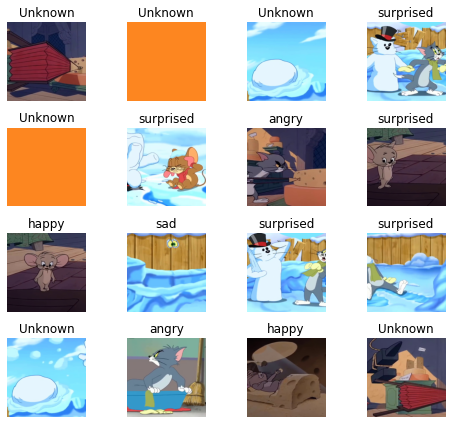

In [7]:
data = ImageDataBunch.from_df(path = "",
                              df = df_train,
                              fn_col = "filename",
                              label_col = "Emotion",
                              #ds_tfms = transforms,
                             size=512)\
        .normalize(imagenet_stats)

data.show_batch(rows=4, figsize=(7,6))

In [8]:
kappa = KappaScore()
kappa.weights = "quadratic"
learn = cnn_learner(data, models.squeezenet1_1,
                    metrics=[error_rate, kappa])

Downloading: "https://download.pytorch.org/models/squeezenet1_1-f364aa15.pth" to /root/.cache/torch/checkpoints/squeezenet1_1-f364aa15.pth


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 4.19E-03
Min loss divided by 10: 1.46E-02


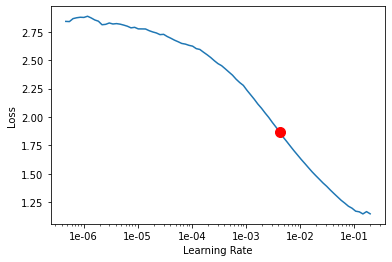

In [9]:
learn.lr_find(end_lr=0.5)
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,error_rate,kappa_score,time
0,2.509966,7.058945,0.830508,0.142940,00:14
1,1.987332,7.869007,0.711864,0.287584,00:12
2,1.540271,4.507955,0.559322,0.333349,00:12
3,1.262011,3.729561,0.440678,0.486093,00:12
4,1.051685,2.185199,0.372881,0.596404,00:12
5,0.914566,1.238366,0.288136,0.753584,00:12
6,0.791685,1.211408,0.271186,0.766234,00:12
7,0.700107,1.188612,0.220339,0.780149,00:12
8,0.632879,1.181271,0.254237,0.721474,00:13
9,0.577628,1.075558,0.237288,0.723353,00:13


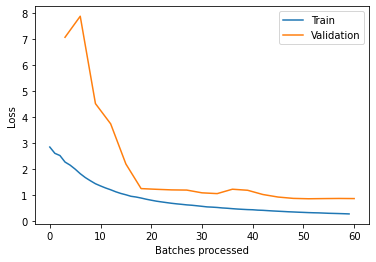

In [10]:
lr = 1.25e-2
learn.fit_one_cycle(20, lr)
learn.recorder.plot_losses()

epoch,train_loss,valid_loss,error_rate,kappa_score,time
0,0.128203,0.829723,0.186441,0.700305,00:17
1,0.088046,0.841038,0.237288,0.669776,00:13
2,0.081508,0.927472,0.220339,0.723005,00:13
3,0.067660,1.125456,0.186441,0.727363,00:13
4,0.070668,1.255146,0.220339,0.697470,00:13
5,0.066853,1.354344,0.271186,0.632692,00:13
6,0.073374,1.321730,0.254237,0.699246,00:13
7,0.079470,1.251592,0.169492,0.804323,00:13
8,0.088696,1.654935,0.355932,0.667984,00:14
9,0.126011,2.044678,0.322034,0.796396,00:14


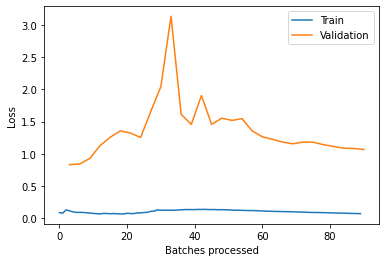

In [11]:
learn.unfreeze()
lrs = slice(lr/400,lr/4)
learn.fit_one_cycle(30,lrs)

learn.recorder.plot_losses()

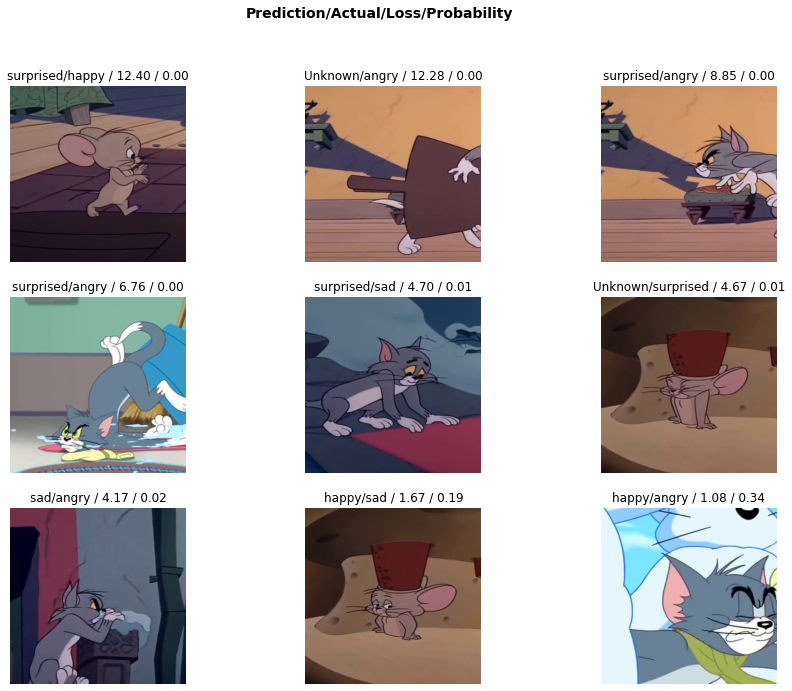

In [12]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(9, figsize=(15,11))

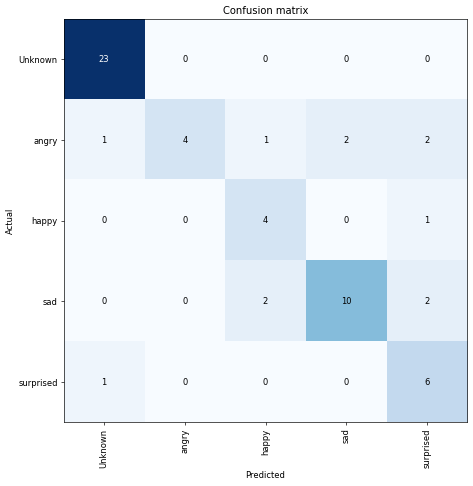

In [13]:
interp.plot_confusion_matrix(figsize=(8,8), dpi=60)

In [14]:
df_test['Emotion'] = 'pred'
df_test.head()

,Frame_ID,filename,Emotion
0,test0.jpg,Data/test/test0.jpg,pred
1,test1.jpg,Data/test/test1.jpg,pred
2,test2.jpg,Data/test/test2.jpg,pred
3,test3.jpg,Data/test/test3.jpg,pred
4,test4.jpg,Data/test/test4.jpg,pred


In [0]:
#------------------------------------------------------------
import shutil
shutil.rmtree('Data')

In [0]:
!unzip Dataset.zip

In [0]:
learn.data.add_test(ImageList.from_df(
    df_test, PATH,
    folder='Data/test',
    #suffix='.jpg'
))

In [22]:
preds,y = learn.get_preds(DatasetType.Test)
df_test['Emotion'] = preds.argmax(1)
df_test.head()

,Frame_ID,filename,Emotion
0,test0.jpg,Data/test/test0.jpg,4
1,test1.jpg,Data/test/test1.jpg,4
2,test2.jpg,Data/test/test2.jpg,1
3,test3.jpg,Data/test/test3.jpg,2
4,test4.jpg,Data/test/test4.jpg,2


In [23]:
dic = learn.data.c2i
mapp = {v: k for k, v in dic.items()}
mapp

{0: 'Unknown', 1: 'angry', 2: 'happy', 3: 'sad', 4: 'surprised'}

In [24]:
df_test.drop(['filename'], axis=1, inplace=True)
df_test.head()

,Frame_ID,Emotion
0,test0.jpg,4
1,test1.jpg,4
2,test2.jpg,1
3,test3.jpg,2
4,test4.jpg,2


In [25]:
submit = pd.DataFrame(columns=['Image', 'Emotion'])
submit

,Image,Emotion


In [26]:
for index, row in df_test.iterrows():
  row['Emotion'] = mapp.get(row.Emotion)
  submit[index] = row
  
  
submit.head()

,Image,Emotion,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,...,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185
Frame_ID,NaN,NaN,test0.jpg,test1.jpg,test2.jpg,test3.jpg,test4.jpg,test5.jpg,test6.jpg,test7.jpg,test8.jpg,test9.jpg,test10.jpg,test11.jpg,test12.jpg,test13.jpg,test14.jpg,test15.jpg,test16.jpg,test17.jpg,test18.jpg,test19.jpg,test20.jpg,test21.jpg,test22.jpg,test23.jpg,test24.jpg,test25.jpg,test26.jpg,test27.jpg,test28.jpg,test29.jpg,test30.jpg,test31.jpg,test32.jpg,test33.jpg,test34.jpg,test35.jpg,test36.jpg,test37.jpg,...,test146.jpg,test147.jpg,test148.jpg,test149.jpg,test150.jpg,test151.jpg,test152.jpg,test153.jpg,test154.jpg,test155.jpg,test156.jpg,test157.jpg,test158.jpg,test159.jpg,test160.jpg,test161.jpg,test162.jpg,test163.jpg,test164.jpg,test165.jpg,test166.jpg,test167.jpg,test168.jpg,test169.jpg,test170.jpg,test171.jpg,test172.jpg,test173.jpg,test174.jpg,test175.jpg,test176.jpg,test177.jpg,test178.jpg,test179.jpg,test180.jpg,test181.jpg,test182.jpg,test183.jpg,test184.jpg,test185.jpg
Emotion,NaN,NaN,surprised,surprised,angry,happy,happy,Unknown,Unknown,sad,surprised,surprised,surprised,surprised,Unknown,angry,happy,surprised,happy,happy,happy,Unknown,angry,Unknown,happy,surprised,happy,happy,Unknown,happy,Unknown,happy,surprised,surprised,angry,surprised,surprised,Unknown,sad,Unknown,...,Unknown,surprised,Unknown,angry,angry,happy,angry,surprised,angry,angry,happy,happy,happy,happy,happy,happy,happy,angry,happy,happy,happy,happy,happy,happy,happy,happy,surprised,happy,surprised,happy,angry,happy,happy,Unknown,Unknown,happy,happy,happy,happy,surprised


In [27]:
submit = submit.T
submit.head()

,Frame_ID,Emotion
Image,NaN,NaN
Emotion,NaN,NaN
0,test0.jpg,surprised
1,test1.jpg,surprised
2,test2.jpg,angry


In [28]:
submit.drop(['Image', 'Emotion'], axis=0, inplace=True)
submit.head()

,Frame_ID,Emotion
0,test0.jpg,surprised
1,test1.jpg,surprised
2,test2.jpg,angry
3,test3.jpg,happy
4,test4.jpg,happy


In [0]:
submit.to_csv('submit_toon(2).csv', index=False)